# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc

from physical_parameters_SciNet.model_instances.n1_setting_synthetic_forced_damped_pendulum import config

#### One damped forced pendulum with a constant forcing

In [44]:
def create_synthetic_damped_forced_pendulum(A: float, omega: float, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
    kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - beta * omega_t - kapa * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [45]:
A = 1.0
omega = 3.0
beta = 0.2
kapa = 3.0
theta0 = 0.9  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, beta, kapa, theta0, omega0, t)

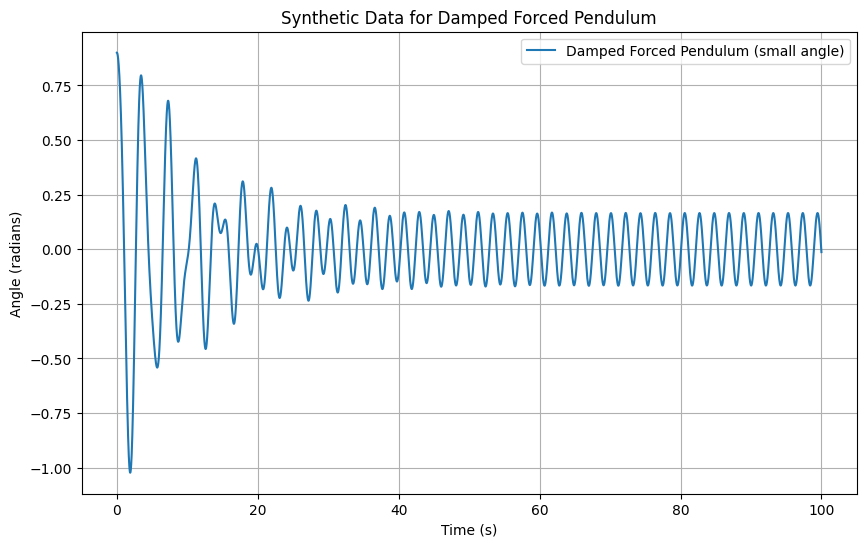

In [46]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [47]:
def create_trapezoidal_forcing(t: np.ndarray, start_value: float, end_value: float, proportions: list[float], N_time_steps: int) -> np.ndarray:
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

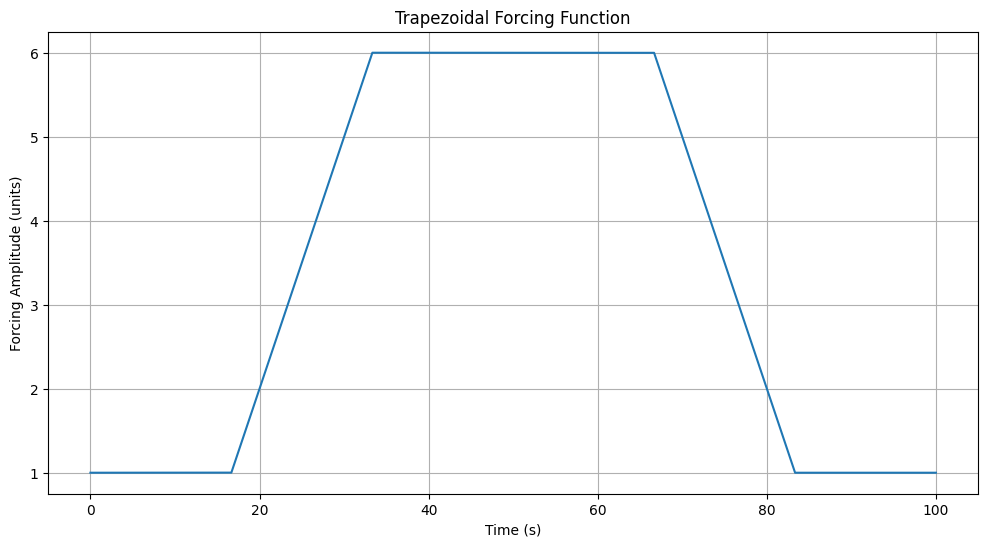

In [48]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Time (s)')
plt.ylabel('Forcing Amplitude (units)')
plt.title('Trapezoidal Forcing Function')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [49]:
def create_synthetic_damped_forced_pendulum(A_array: np.ndarray, omega_array: np.ndarray, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (numpy array): Amplitude of the forcing term (time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
        kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if len(A_array) != len(t):
        raise ValueError("If A is an array, it must have the same length as t")


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - beta * omega_t - kapa * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [50]:
# Time array
N_time_steps = 2000
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
A_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=10.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
omega_value = 1.0
omega_array = np.ones(N_time_steps) * omega_value
# Parameters
beta = 0.1
kapa = 10.0
theta0 = 1.0
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A_array, omega_array, beta, kapa, theta0, omega0, t)

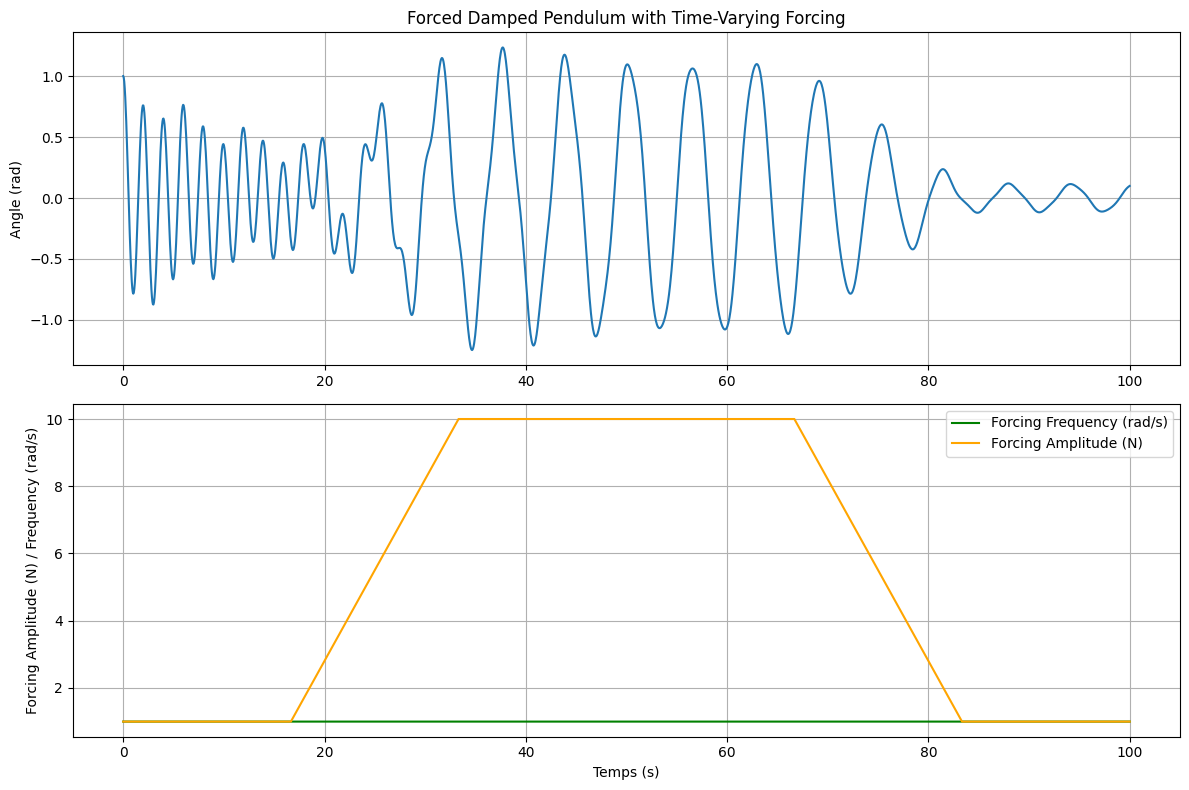

In [51]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Forced Damped Pendulum with Time-Varying Forcing')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Forcing Frequency (rad/s)')
ax2.plot(t, A_array, color='orange', label='Forcing Amplitude (N)')
ax2.set_ylabel('Forcing Amplitude (N) / Frequency (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* theta0: fixed
* omega0: fixed
* kapa: varying randomly
* beta: varying randomly
* omega_forcing: choosen among a discret number


In [52]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        kapa_range: tuple, 
        beta_range: tuple, 
        trapezoidal_forcing_values: dict,
        A_value: float | None = 1.0,
        omega_value: float | None = 1.0,
        theta0: float = 0.5, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        kapa_range (tuple): Tuple defining the range of spring constants (min, max).
        beta_range (tuple): Tuple defining the range of damping coefficients (min, max).
        trapezoidal_forcing_values (dict): dictionary of args for the forcing parameters.
        A_value (float or None): Amplitude of the forcing term (constant or variable).
        omega_forcing_values (float or None): Pulsation of the forcing term (constant or variable).

    Parameters:
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    assert (A_value is not None) ^ (omega_value is not None), "Either A_value or omega_value must be provided as constant."

    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        trap_start, trap_end = 1.0, 0.0
        while trap_start >= trap_end:
            trap_start = np.random.uniform(*trapezoidal_forcing_values["start_value"])
            trap_end = np.random.uniform(*trapezoidal_forcing_values["end_value"])
        proportions = [np.random.uniform(*trapezoidal_forcing_values["proportions"][a]) for a in range(4)]
        trap_forcing_values_sampled = {
            "start_value": trap_start,
            "end_value": trap_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        if omega_value is not None:
            A_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            omega_forcing = np.ones(n_timestep) * omega_value
        else:
            omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            A_forcing = np.ones(n_timestep) * A_value

        # Randomly sample kapa and beta within their respective ranges
        kapa = np.random.uniform(*kapa_range)
        beta = np.random.uniform(*beta_range)

        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_forcing, omega_forcing, beta, kapa, theta0, omega0, t)

        # Store the parameters and the resulting angle array
        sample = {
            'kapa': kapa,
            'beta': beta,
            'forcing': omega_forcing if omega_value is None else A_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [ ]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
trapezoidal_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

beta_range = config.BETA_RANGE
kapa_range = config.KAPA_RANGE
N_samples = config.N_SAMPLES
N_time_steps = config.TIMESTEPS
max_time = config.MAXTIME

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    kapa_range=kapa_range,
    beta_range=beta_range,
    trapezoidal_forcing_values=trapezoidal_forcing_ranges,
    A_value=config.A_VALUE,
    omega_value=config.OMEGA_VALUE,
    theta0=config.THETA0,
    omega0=config.OMEGA0
)

  0%|          | 0/20000 [00:00<?, ?it/s]

  1%|          | 118/20000 [00:03<10:08, 32.69it/s]


KeyboardInterrupt: 

In [ ]:
len(dataset)

20000

In [53]:
path = config.DIR_RAW_DATA / "synthetic_damped_forced_pendulum_dataset.npy"

#np.save(path, dataset)
dataset = np.load(path, allow_pickle=True)

In [54]:
dataset[0]

{'kapa': 1.6326304372798894,
 'beta': 4.3977926559872085,
 'forcing': array([1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.22359505, 1.38537993, 1.5471648 , 1.70894968,
        1.87073455, 2.03251942, 2.1943043 , 2.35608917, 2.51787405,
        2.67965892, 2.8414438 , 3.00322867, 3.16501354, 3.32679842,
        3.48858329, 3.65036817, 3.81215304, 3.97393792, 4.13572279,
        4.29750766, 4.45929254, 4.62107741, 4.78286229, 4.94464716,
        5.10643203, 5.26821691, 5.43000178, 5.5

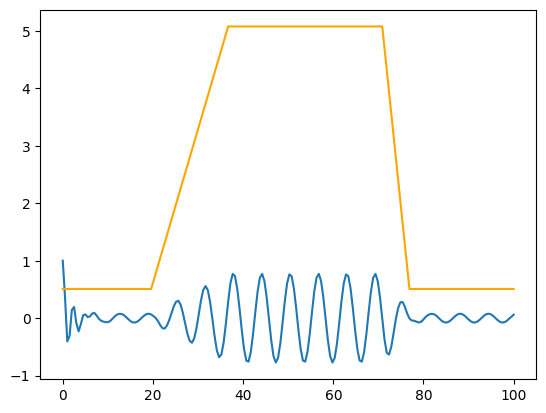

In [55]:
id_to_plot = 9
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['angle'])
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [56]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [57]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['forcing'], dtype=torch.float32)
        params = torch.tensor([sample['kapa'], sample['beta']], dtype=torch.float32)
        return observations, questions, params

In [58]:
split_ratio = config.SPLIT_RATIO  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [59]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 14000
Validation size: 3000
Test size: 3000
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [60]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)

#### Scinet network

In [61]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [62]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [63]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [64]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:

    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = config.DIR_PARAMS_CHECKPOINTS / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [65]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = config.DIR_FIGURES / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [66]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [67]:
### SCINET architecture
TIMESTEPS = config.TIMESTEPS  # 200
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = config.M_ENC_HIDDEN_SIZES  # [500, 100] # [500, 100, 100]
M_LATENT_SIZE = config.M_LATENT_SIZE  # 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = config.M_DEC_HIDDEN_SIZES  # [500, 500] # [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = config.BATCH_SIZE_TRAIN  # 50
BATCH_SIZE_VALID = config.BATCH_SIZE_EVAL  # 50
FIRST_LEARNING_RATE = config.FIRST_LEARNING_RATE  # 5e-4
WEIGHT_DECAY = config.WEIGHT_DECAY  # 1e-6
KLD_BETA = config.KLD_BETA  # 0.0003

### Train parameters
NUM_EPOCHS = config.NUM_EPOCHS  # 150
ES_PATIENCE = config.ES_PATIENCE  # 12
ES_MIN_DELTA = config.ES_MIN_DELTA  # 5e-4
GC_MAX_NORM = config.GC_MAX_NORM  # 1.0
LRS_FACTOR = config.LRS_FACTOR  # 0.66
LRS_PATIENCE = config.LRS_PATIENCE  # 5
LRS_MIN_LR = config.LRS_MIN_LR  # 1e-7
LRS_MIN_DELTA = config.LRS_MIN_DELTA  # 1e-4

In [68]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [69]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = config.DIR_MODEL_PARAMS / (config.BEST_MODEL_NAME + ".pth")
torch.save(pendulum_net.state_dict(), path)

------training on cuda:1-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  0.090294         |  2.266713     0.088028        |    0.047028       


2/150                 |  0.038277         |  4.685531     0.033591        |    0.041324       


3/150                 |  0.033700         |  4.151002     0.029549        |    0.031618       


4/150                 |  0.016548         |  5.903742     0.010644        |    0.013399       


5/150                 |  0.011678         |  5.250693     0.006427        |    0.011678       


6/150                 |  0.010245         |  4.863568     0.005382        |    0.009995       


7/150                 |  0.009357         |  4.595859     0.004761        |    0.009305       


8/150                 |  0.008669         |  4.430106     0.004239        |    0.008861       


9/150                 |  0.008238         |  4.272805     0.003965        |    0.008326       


10/150                |  0.007861         |  4.143414     0.003717        |    0.008244       


11/150                |  0.007517         |  4.036757     0.003480        |    0.007480       


12/150                |  0.007245         |  3.965271     0.003279        |    0.007156       


13/150                |  0.007018         |  3.878907     0.003139        |    0.007020       


14/150                |  0.006797         |  3.821038     0.002976        |    0.007049       


15/150                |  0.006564         |  3.784511     0.002780        |    0.006622       


16/150                |  0.006465         |  3.737235     0.002727        |    0.006730       


17/150                |  0.006380         |  3.701412     0.002679        |    0.006309       


18/150                |  0.006198         |  3.657896     0.002540        |    0.006289       


19/150                |  0.006102         |  3.594409     0.002508        |    0.006024       


20/150                |  0.006010         |  3.587582     0.002422        |    0.006046       


21/150                |  0.005977         |  3.535403     0.002441        |    0.006513       


22/150                |  0.005758         |  3.499907     0.002258        |    0.005830       


23/150                |  0.005734         |  3.450875     0.002283        |    0.005849       


24/150                |  0.005660         |  3.422492     0.002237        |    0.005698       


25/150                |  0.005586         |  3.382411     0.002204        |    0.005731       


26/150                |  0.005505         |  3.353003     0.002152        |    0.005846       


27/150                |  0.005419         |  3.302293     0.002116        |    0.005371       


28/150                |  0.005353         |  3.267164     0.002086        |    0.005405       


29/150                |  0.005336         |  3.232402     0.002104        |    0.005322       


30/150                |  0.005263         |  3.208780     0.002054        |    0.005217       


31/150                |  0.005202         |  3.166378     0.002036        |    0.005195       


32/150                |  0.005119         |  3.151558     0.001967        |    0.005223       


33/150                |  0.005020         |  3.138749     0.001881        |    0.005244       


34/150                |  0.004999         |  3.120820     0.001878        |    0.005025       


35/150                |  0.005053         |  3.114649     0.001938        |    0.005005       


36/150                |  0.005032         |  3.110321     0.001922        |    0.005184       


37/150                |  0.004977         |  3.084243     0.001892        |    0.005262       


38/150                |  0.005045         |  3.112434     0.001932        |    0.004862       


39/150                |  0.004974         |  3.085683     0.001889        |    0.005018       


40/150                |  0.004852         |  3.080523     0.001772        |    0.004962       


41/150                |  0.004839         |  3.069214     0.001770        |    0.005157       


42/150                |  0.004782         |  3.066393     0.001716        |    0.004825       


43/150                |  0.004882         |  3.083800     0.001798        |    0.005721       


44/150                |  0.004861         |  3.058722     0.001802        |    0.004793       


45/150                |  0.004792         |  3.074203     0.001718        |    0.004881       


46/150                |  0.004762         |  3.062263     0.001700        |    0.004994       


47/150                |  0.004833         |  3.054123     0.001779        |    0.004857       


48/150                |  0.004696         |  3.054281     0.001642        |    0.004865       


49/150                |  0.004794         |  3.050961     0.001743        |    0.005026       


50/150                |  0.004747         |  3.068766     0.001679        |    0.004865       
Reduced learning rate from 5.00e-05 to 3.30e-05


51/150                |  0.004644         |  3.045785     0.001598        |    0.004703       


52/150                |  0.004612         |  3.045124     0.001567        |    0.004812       


53/150                |  0.004593         |  3.045357     0.001548        |    0.004662       


54/150                |  0.004636         |  3.046762     0.001589        |    0.004733       


55/150                |  0.004584         |  3.029894     0.001554        |    0.004826       


56/150                |  0.004664         |  3.037133     0.001627        |    0.004916       


57/150                |  0.004554         |  3.035858     0.001518        |    0.004664       


58/150                |  0.004584         |  3.040950     0.001543        |    0.004664       


59/150                |  0.004583         |  3.034540     0.001549        |    0.004701       
Reduced learning rate from 3.30e-05 to 2.18e-05


60/150                |  0.004505         |  3.021273     0.001483        |    0.004584       


61/150                |  0.004493         |  3.011881     0.001481        |    0.004718       


62/150                |  0.004515         |  3.016370     0.001499        |    0.004579       


63/150                |  0.004469         |  3.022644     0.001446        |    0.004532       


64/150                |  0.004499         |  3.017622     0.001481        |    0.004679       


65/150                |  0.004470         |  3.010653     0.001459        |    0.004580       


66/150                |  0.004477         |  2.993098     0.001484        |    0.004587       


67/150                |  0.004502         |  3.018724     0.001484        |    0.004558       


68/150                |  0.004437         |  3.009007     0.001428        |    0.004638       


69/150                |  0.004466         |  3.002472     0.001463        |    0.004720       
Reduced learning rate from 2.18e-05 to 1.44e-05


70/150                |  0.004435         |  3.014212     0.001420        |    0.004549       


71/150                |  0.004440         |  3.012272     0.001428        |    0.004705       


72/150                |  0.004441         |  3.005645     0.001435        |    0.004554       


73/150                |  0.004429         |  3.008014     0.001421        |    0.004578       


74/150                |  0.004412         |  3.000632     0.001411        |    0.004498       


75/150                |  0.004419         |  3.004874     0.001415        |    0.004654       
Early stopping at epoch 75 with loss 0.0047
Restoring best weights for model.


Early stopping on validation loss at epoch 49/150

Final train loss: 0.004636
    - Final train kld loss: 3.173079
    - Final train recon loss: 0.001463

Final val loss: 0.004525

In [ ]:
# Load best model
# pendulum_net.load_state_dict(torch.load(path))

/tmp/ipykernel_3566204/3102714156.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pendulum_net.load_state_dict(torch.load(path))


UnpicklingError: unpickling stack underflow

In [ ]:
# print(pendulum_net)

In [ ]:
# model_weight = torch.load(path)
# print(model_weight.keys())

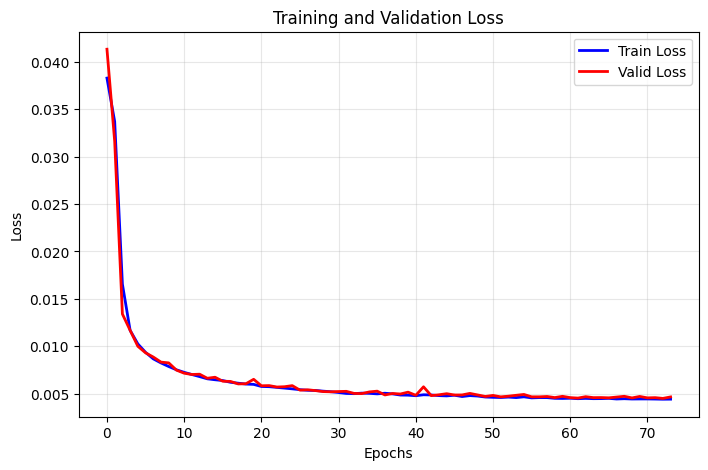

In [70]:
plot_history(history['train_loss'][1:], history['valid_loss'][1:])

#### Test pendulumenet

In [71]:
sample_idx = np.random.choice(config.TEST_SIZE)
sample_idx

2400

In [72]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

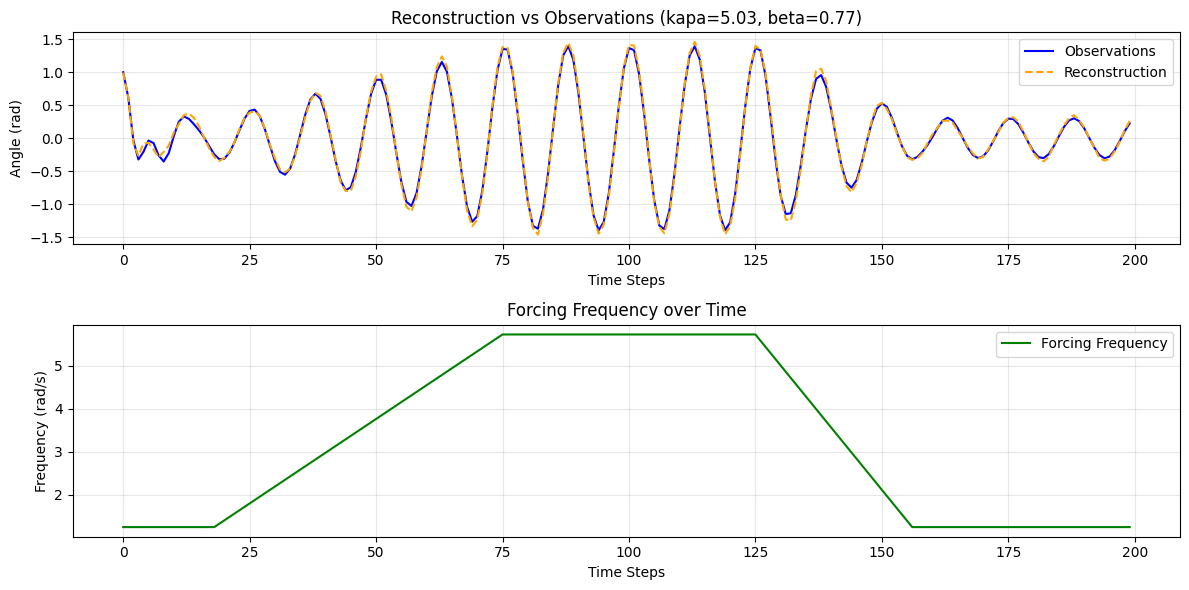

In [73]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (kapa={L:.2f}, beta={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

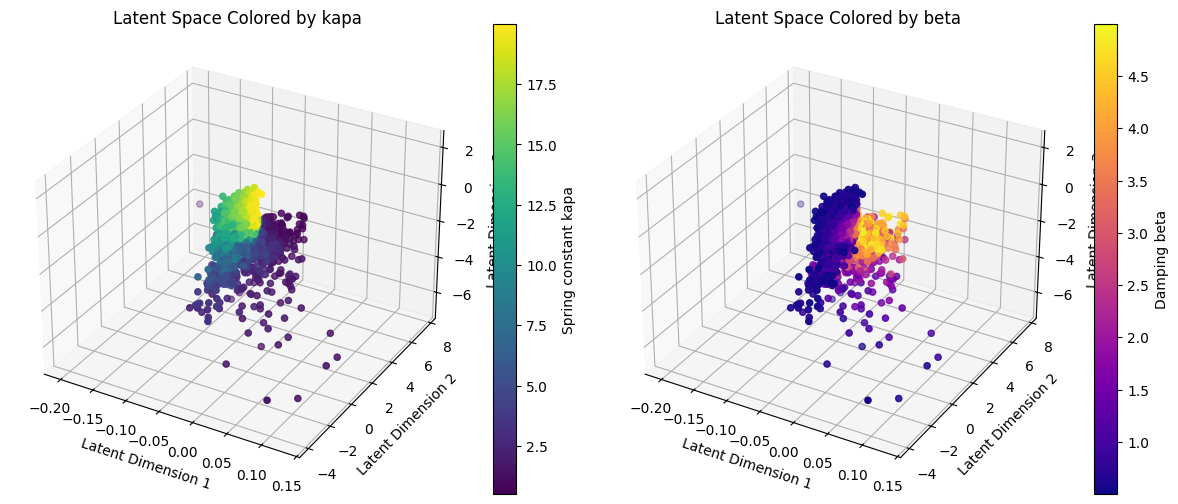

In [74]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Spring constant kapa')
ax.set_title('Latent Space Colored by kapa')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping beta')
ax.set_title('Latent Space Colored by beta')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

In [75]:
print(pendulum_net)

PendulumNet(
  (encoder): SciNetEncoder(
    (layers): ModuleList(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Linear(in_features=200, out_features=70, bias=True)
    )
    (activations): ModuleList(
      (0-1): 2 x ELU(alpha=1.0)
    )
    (mean_layer): Linear(in_features=70, out_features=3, bias=True)
    (logvar_layer): Linear(in_features=70, out_features=3, bias=True)
  )
  (decoder): QuestionDecoder(
    (layers): ModuleList(
      (0): Linear(in_features=203, out_features=500, bias=True)
      (1-2): 2 x Linear(in_features=500, out_features=500, bias=True)
      (3): Linear(in_features=500, out_features=200, bias=True)
    )
    (activations): ModuleList(
      (0-2): 3 x ELU(alpha=1.0)
      (3): Identity()
    )
  )
)


### Plot Latent neurons activations vs physical parameters

In [76]:
def get_one_latent_activation(
    model: nn.Module, observation: np.array, question: np.array, device: torch.device = torch.device("cpu")
) -> np.array:
    """
    Get the latent activation for a single observation.

    Args:
        model (nn.Module): The trained model.
        observation (np.array): The input observation.
        device (torch.device, optional): The device to run the model on. Defaults to CPU.

    Returns:
        np.array: The latent activation.
    """
    torch.cuda.empty_cache()
    model.to(device).eval()
    observation_tensor = (torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device))
    #question_tensor = (torch.tensor(question, dtype=torch.float32).unsqueeze(0).to(device))
    latent_activations = []
    with torch.no_grad():
        mean, _ = model.encoder(observation_tensor)
        latent_activations.append(mean.cpu().numpy())
    return np.array(latent_activations)

In [77]:
def get_latent_activations(
    model: nn.Module,
    kapa_range: tuple,
    b_range: tuple,
    pixel_by_line: int = 50,
    device: torch.device = torch.device("cpu"),
) -> tuple[np.array]:
    """
    Get the latent activations for a grid of (kapa, b) values.

    Args:
        model (nn.Module): The trained model.
        kapa_range (tuple): Range of kapa values (min, max).
        b_range (tuple): Range of b values (min, max).
        pixel_by_line (int, optional): Number of points per axis. Defaults to 50.
        device (torch.device, optional): The device to run the model on. Defaults to CPU

    Returns:
        3-tuple containing:
            np.array: The grid of kapa values
            np.array: The grid of b values
            np.array: The latent activations for the grid of (kapa, b) values
    """
    # Create a grid of (kapa, b) values
    kapa_values = np.linspace(*kapa_range, pixel_by_line)
    b_values = np.linspace(*b_range, pixel_by_line)
    kapa_grid, b_grid = np.meshgrid(kapa_values, b_values)

    # Loop over the grid and get latent activations
    latent_activations = []
    for kapa in kapa_values:
        for beta in b_values:
            # Generate observation
            eps = 0
            trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
            trapezoidal_forcing_ranges = {
                "start_value": (1.0, 1.0),
                "end_value": (6.0, 6.0),
                "proportions": trapezoid_range,
            }

            beta_range = (beta, beta)
            kapa_range = (kapa, kapa)

            dataset = create_dataset(
                N_sample=1,
                maxtime=config.MAXTIME,
                n_timestep=config.TIMESTEPS,
                kapa_range=kapa_range,
                beta_range=beta_range,
                trapezoidal_forcing_values=trapezoidal_forcing_ranges,
                A_value=config.A_VALUE,
                omega_value=config.OMEGA_VALUE,
                theta0=config.THETA0,
                omega0=config.OMEGA0
            )

            observation = dataset[0]['angle']
            question = dataset[0]['forcing']

            # Find latent activation with encoder only
            latent_act = get_one_latent_activation(model, observation, question, device=device)
            latent_activations.append(latent_act)
    latents = np.array(latent_activations).reshape(pixel_by_line, pixel_by_line, -1)

    return kapa_grid, b_grid, latents

In [78]:
def plot_3d_latent_activations(
    kapa_grid: np.array,
    b_grid: np.array,
    latent_activations: np.array,
    save_path: str,
    shared_scale: bool = False,
) -> None:
    """ "
    Plot the latent activations in 3D for each latent dimension.

    Args:
        kapa_grid (np.array): The grid of kapa values.
        b_grid (np.array): The grid of b values.
        latent_activations (np.array): The latent activations for the grid of (kapa, b) values.
        save_path (str): Path to save the plot.
        shared_scale (bool, optional): Whether to use a shared z-axis scale for all plots. Defaults to False.

    Returns:
        None
        Figures are saved to the specified path.
    """
    latent_dim = latent_activations.shape[2]
    fig = plt.figure(figsize=(6 * latent_dim, 8))

    if shared_scale:
        z_min = np.min(latent_activations)
        z_max = np.max(latent_activations)
    else:
        z_min = z_max = None

    # Plot each latent dimension
    for i in range(latent_dim):
        ax = fig.add_subplot(1, latent_dim, i + 1, projection="3d")
        surf = ax.plot_surface(
            kapa_grid,
            b_grid,
            latent_activations[:, :, i],
            alpha=0.8,
            cmap="viridis",
            label=f"Latent {i+1}",
        )

        if shared_scale:
            ax.set_zlim(z_min, z_max)
        ax.set_xlabel(r"$\kappa$")
        ax.set_ylabel(r"$b$")
        ax.set_title(f"Latent Dimension {i+1}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    return None

In [79]:
kapa_range = config.KAPA_RANGE
b_range = config.BETA_RANGE

kapa_grid, b_grid, latent_activations = get_latent_activations(
    pendulum_net, kapa_range, b_range, device=device
)

print("Latent activations computed.")

100%|██████████| 1/1 [00:00<00:00, 23.38it/s]

Latent activations computed.


In [80]:
path = config.DIR_FIGURES / "latent_activations_3d_2.png"
plot_3d_latent_activations(
    kapa_grid, b_grid, latent_activations, save_path=path, shared_scale=True
)
print(f"Latent activations plotted. Saved at: {path}")

Latent activations plotted. Saved at: /home/ITER/brussel/Documents/ITER-physical-parameters-with-SciNet/results/figures/latent_activations_3d_2.png
